In [62]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [63]:
! kaggle datasets download minatverma/nse-stocks-data

Dataset URL: https://www.kaggle.com/datasets/minatverma/nse-stocks-data
License(s): CC0-1.0
nse-stocks-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [64]:
import zipfile
zip_ref = zipfile.ZipFile('/content/nse-stocks-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [65]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [66]:
df = pd.read_csv('/content/FINAL_FROM_DF.csv')
df.sample(5)

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
542094,ESL,EQ,3.35,3.40,3.3,3.35,3.35,3.30,886645,2968150.95,2016-09-09,369,INE481K01013
674566,IRFC,NO,1152.45,1153.49,1150.0,1151.95,1152.00,1152.37,3717,4278080.65,2016-12-08,36,INE053F07900
629308,VIJAYABANK,EQ,30.80,31.30,30.3,30.65,30.50,30.55,136837,4223999.70,2016-02-02,1484,INE705A01016
400967,INFOBEAN,SM,67.40,67.50,66.1,66.35,66.35,66.15,10000,667100.00,2017-07-21,5,INE344S01016
157500,GOKUL,EQ,22.80,23.30,22.0,22.40,22.30,22.85,37704,851281.80,2017-07-05,176,INE020J01029


In [67]:
df.shape

(846404, 13)

In [68]:
df.duplicated().sum()

0

In [69]:
print(df['SYMBOL'].value_counts())

SYMBOL
SRTRANSFIN    4709
IDFCBANK      4379
IRFC          4362
NHAI          3360
RECLTD        2919
              ... 
CLASSIC          1
CP7RG            1
IPRU2814         1
ASTRON           1
SGBDEC2512       1
Name: count, Length: 2037, dtype: int64


In [90]:
from datetime import datetime
# Convert 'TIMESTAMP' to datetime format
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

# Get the current date and eight year back
end = datetime.now()
start = datetime(end.year - 8, end.month, end.day)

# Filter data for the last 8 year
df = df[(df['TIMESTAMP'] >= start) & (df['TIMESTAMP'] <= end)]

In [71]:
df.shape

(411661, 13)

Analysis On 'HDFCBANK', 'IDFCBANK', 'IRFC' These Companies

In [72]:
df = df[df['SYMBOL'].isin(['HDFCBANK', 'IDFCBANK', 'IRFC'])]

In [73]:
df.shape

(5125, 13)

In [74]:
df

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
554,HDFCBANK,EQ,1665.0,1675.00,1657.80,1666.45,1666.50,1667.65,1112259,1.853115e+09,2017-06-28,33276,INE040A01026
555,HDFCBANK,IL,1670.0,1670.00,1670.00,1670.00,0.00,1695.00,43000,7.181000e+07,2017-06-28,1,INE040A01026
625,IDFCBANK,EQ,55.3,55.95,54.80,55.30,55.25,55.70,9143866,5.061666e+08,2017-06-28,27629,INE092T01019
626,IDFCBANK,N1,5000.0,5112.50,5000.00,5112.50,5112.50,5150.00,13,6.599850e+04,2017-06-28,6,INE092T08CC6
627,IDFCBANK,N2,8015.0,8015.00,8015.00,8015.00,8015.00,8023.00,8,6.412000e+04,2017-06-28,3,INE092T08CD4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
845320,IRFC,NaN,1235.0,1237.87,1235.00,1237.87,1237.87,1258.89,110,1.361485e+05,2017-12-29,3,INE053F07686
845321,IRFC,NE,1270.5,1270.50,1270.50,1270.50,1270.50,1268.00,100,1.270500e+05,2017-12-29,1,INE053F07744
845322,IRFC,NJ,1121.0,1121.01,1115.00,1117.77,1115.00,1119.15,1314,1.472513e+06,2017-12-29,9,INE053F07835
845323,IRFC,NK,1130.0,1130.00,1126.01,1127.41,1126.01,1126.72,352,3.972009e+05,2017-12-29,5,INE053F07843


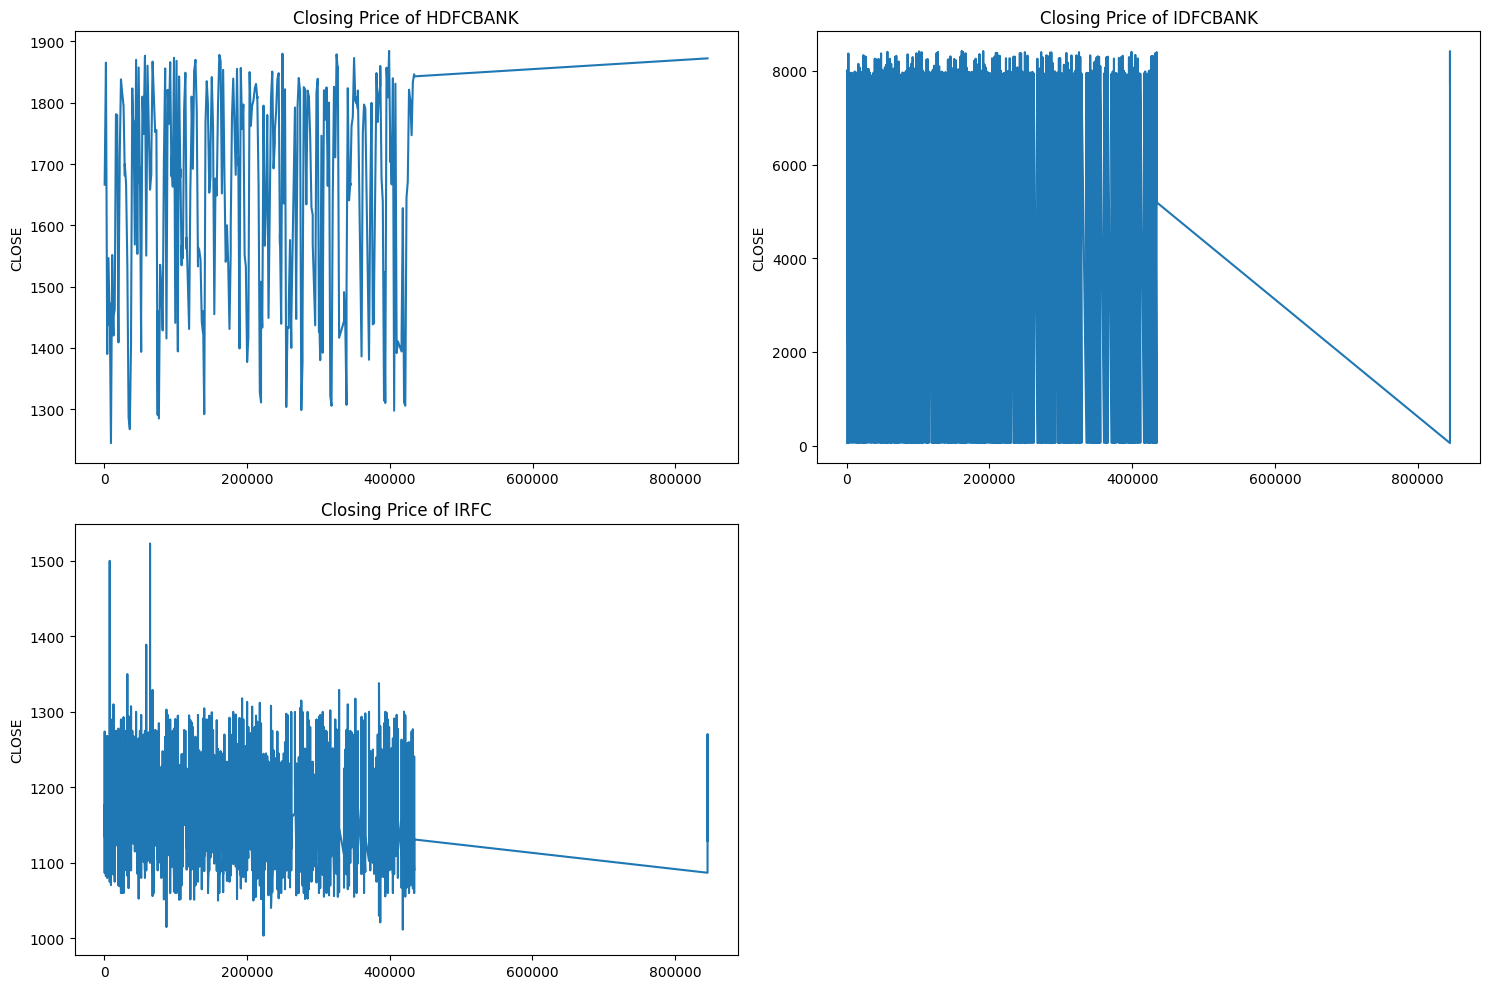

In [75]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(['HDFCBANK', 'IDFCBANK', 'IRFC'], 1):
    plt.subplot(2, 2, i)
    # Filter the DataFrame based on the company name
    company_df = df[df['SYMBOL'] == company]
    # Plot the 'CLOSE' column for the filtered data
    company_df['CLOSE'].plot()
    plt.ylabel('CLOSE')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company}")  # Use company directly for the title

plt.tight_layout()

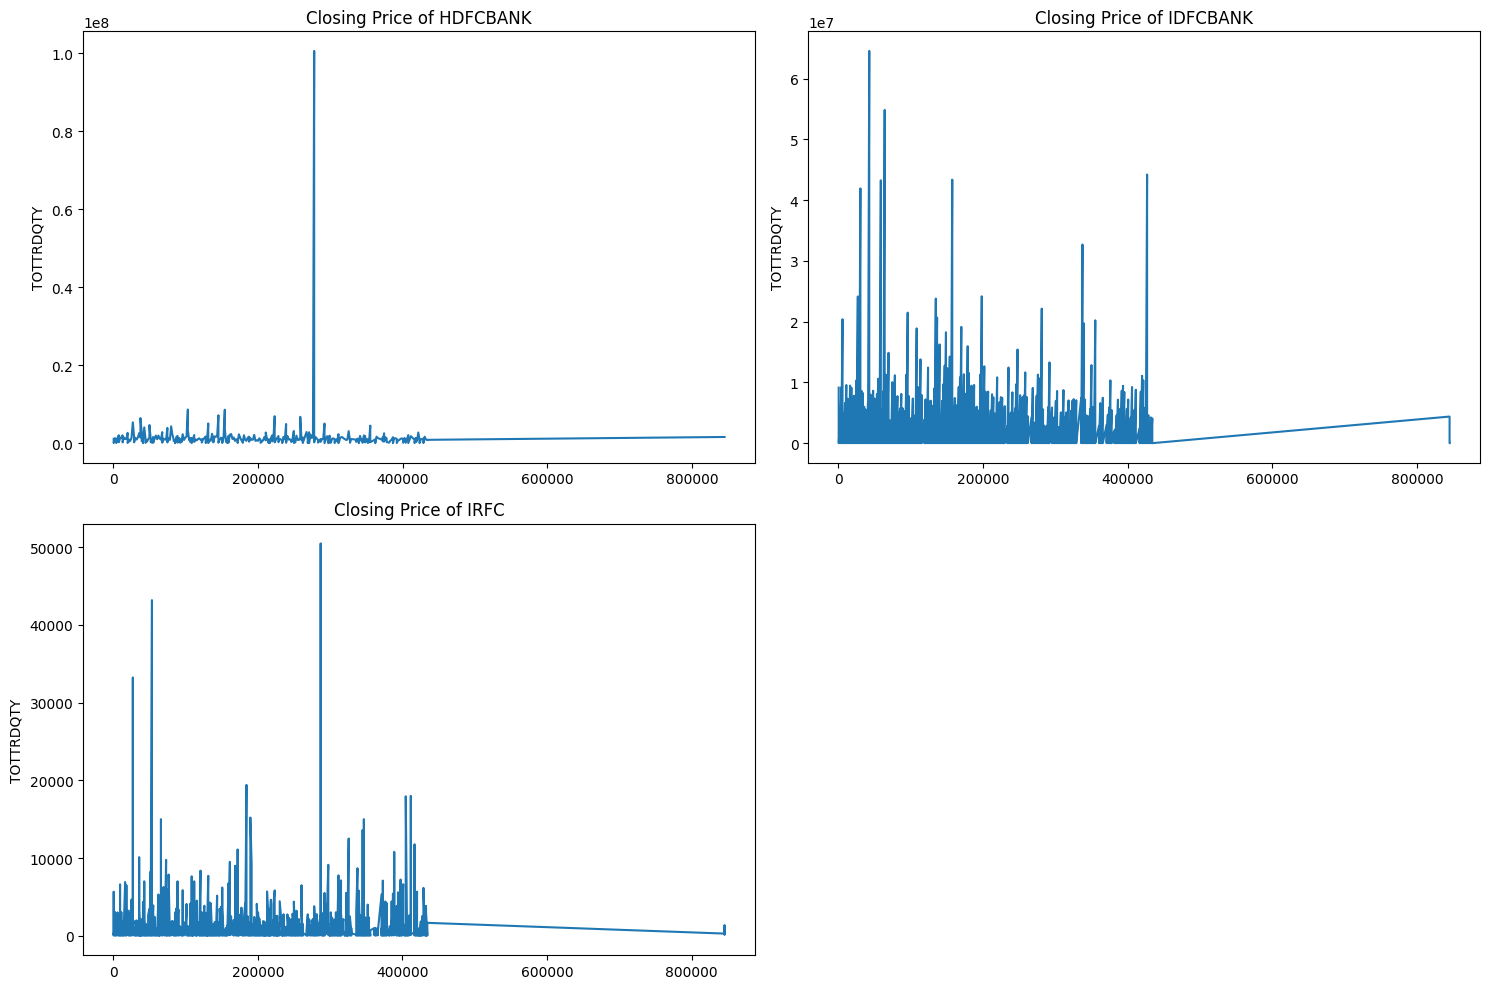

In [76]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(['HDFCBANK', 'IDFCBANK', 'IRFC'], 1):
    plt.subplot(2, 2, i)
    # Filter the DataFrame based on the company name
    company_df = df[df['SYMBOL'] == company]
    # Plot the 'CLOSE' column for the filtered data
    company_df['TOTTRDQTY'].plot()
    plt.ylabel('TOTTRDQTY')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company}")  # Use company directly for the title

plt.tight_layout()

Stock Price Prediction On HDFCBANK

In [77]:
import pandas as pd

# Filter the data for 'HDFCBANK'
df_filtered = df[df['SYMBOL'] == 'HDFCBANK']

# Select only the required columns
df_filtered = df_filtered[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TOTALTRADES', 'TIMESTAMP']]

# Convert 'TIMESTAMP' to datetime if not already
df_filtered['TIMESTAMP'] = pd.to_datetime(df_filtered['TIMESTAMP'])

# Set 'TIMESTAMP' as the index
df_filtered.set_index('TIMESTAMP', inplace=True)

# Display the filtered data with 'TIMESTAMP' as index
print(df_filtered.head())


              OPEN     HIGH      LOW    CLOSE  TOTALTRADES
TIMESTAMP                                                 
2017-06-28  1665.0  1675.00  1657.80  1666.45        33276
2017-06-28  1670.0  1670.00  1670.00  1670.00            1
2017-11-28  1856.0  1871.00  1855.85  1865.35        44306
2017-02-28  1392.9  1396.25  1384.50  1390.10        19486
2017-02-28  1440.0  1440.00  1440.00  1440.00            2


In [78]:
print(type(df_filtered.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [79]:
print(df_filtered.index.duplicated().sum())

94


In [80]:
df_filtered = df_filtered.groupby(df_filtered.index).agg({
    'OPEN': 'mean',          # Average opening price
    'HIGH': 'max',           # Maximum high price
    'LOW': 'min',            # Minimum low price
    'CLOSE': 'mean',         # Average closing price
    'TOTALTRADES': 'sum'     # Total trades
})

In [81]:
print(df_filtered.index.duplicated().sum())

0


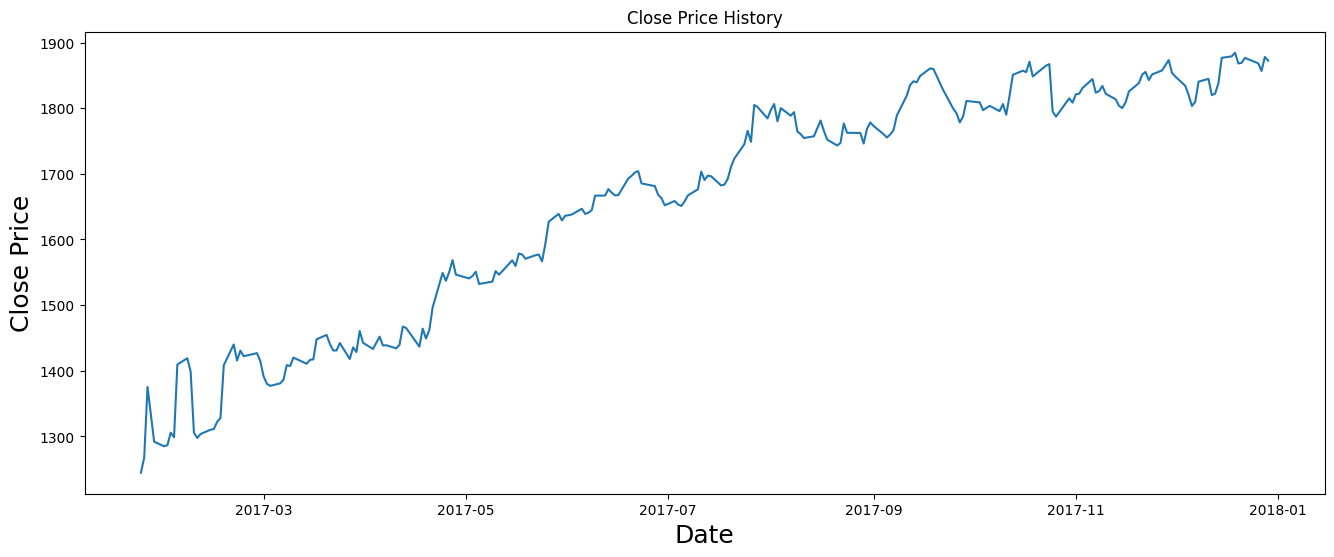

In [82]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_filtered['CLOSE'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [83]:
# Create a new dataframe with only the 'Close column
data = df_filtered.filter(['CLOSE'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

187

In [84]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.03578964],
       [0.20418848],
       [0.07384543],
       [0.06298351],
       [0.06564038],
       [0.09541299],
       [0.08447292],
       [0.25767758],
       [0.27256388],
       [0.24095491],
       [0.09533484],
       [0.08283191],
       [0.09213097],
       [0.10244589],
       [0.10385247],
       [0.12120028],
       [0.13010862],
       [0.25611471],
       [0.30538407],
       [0.26709385],
       [0.29057592],
       [0.27740877],
       [0.2846761 ],
       [0.26631242],
       [0.22974135],
       [0.21169024],
       [0.20684535],
       [0.2127061 ],
       [0.22122372],
       [0.25623193],
       [0.25388763],
       [0.27412675],
       [0.25951395],
       [0.26873486],
       [0.26990701],
       [0.31769165],
       [0.32804564],
       [0.30679065],
       [0.29108385],
       [0.29108385],
       [0.30870517],
       [0.27080566],
       [0.29842932],
       [0.28748926],
       [0.33750098],
       [0.30929124],
       [0.294

In [85]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.        , 0.03578964, 0.20418848, 0.07384543, 0.06298351,
       0.06564038, 0.09541299, 0.08447292, 0.25767758, 0.27256388,
       0.24095491, 0.09533484, 0.08283191, 0.09213097, 0.10244589,
       0.10385247, 0.12120028, 0.13010862, 0.25611471, 0.30538407,
       0.26709385, 0.29057592, 0.27740877, 0.2846761 , 0.26631242,
       0.22974135, 0.21169024, 0.20684535, 0.2127061 , 0.22122372,
       0.25623193, 0.25388763, 0.27412675, 0.25951395, 0.26873486,
       0.26990701, 0.31769165, 0.32804564, 0.30679065, 0.29108385,
       0.29108385, 0.30870517, 0.27080566, 0.29842932, 0.28748926,
       0.33750098, 0.30929124, 0.29467844, 0.32394311, 0.30296163,
       0.30350863, 0.29616316, 0.3045245 , 0.34805032, 0.34461202,
       0.30030476, 0.34304915, 0.31937173, 0.33992342, 0.39376416])]
[0.47569742908494184]

[array([0.        , 0.03578964, 0.20418848, 0.07384543, 0.06298351,
       0.06564038, 0.09541299, 0.08447292, 0.25767758, 0.27256388,
       0.24095491, 0.09533484, 0.08

In [86]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

# Build the improved LSTM model
model = Sequential()

# First LSTM layer with more units
model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.3))  # Slightly increase dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))

# Third LSTM layer
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dropout(0.3))

# Dense layers for more expressiveness
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Output layer

# Compile with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 60, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 60, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │           3,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 514,021 (1.96 MB)

 Trainable params: 514,021 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
from keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=1,  # Use a more efficient batch size
    epochs=100,  # Train for more epochs
    validation_split=0.2,  # Use part of the training data for validation
    callbacks=[early_stopping],  # Stop if no improvement
    verbose=1
)


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0941 - mae: 0.2286 - val_loss: 0.0216 - val_mae: 0.1379
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0113 - mae: 0.0850 - val_loss: 0.0381 - val_mae: 0.1885
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0141 - mae: 0.0946 - val_loss: 0.0151 - val_mae: 0.1118
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0156 - mae: 0.1038 - val_loss: 0.0149 - val_mae: 0.1116
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0120 - mae: 0.0894 - val_loss: 0.0074 - val_mae: 0.0703
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0095 - mae: 0.0779 - val_loss: 0.0046 - val_mae: 0.0518
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0078 - mae: 0.0702 - val_loss: 0.0044 - val_mae: 0.0508
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0098 - mae: 0.0791 - val_loss: 0.0207 - val_mae: 0.1349
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━

In [88]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

print("Root Mean Squared Error (RMSE):", rmse)

# R² Score Calculation
r2 = r2_score(y_test, predictions)
print("R² Score:", r2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
Root Mean Squared Error (RMSE): 24.337200751422767
R² Score: 0.10629540184370923


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

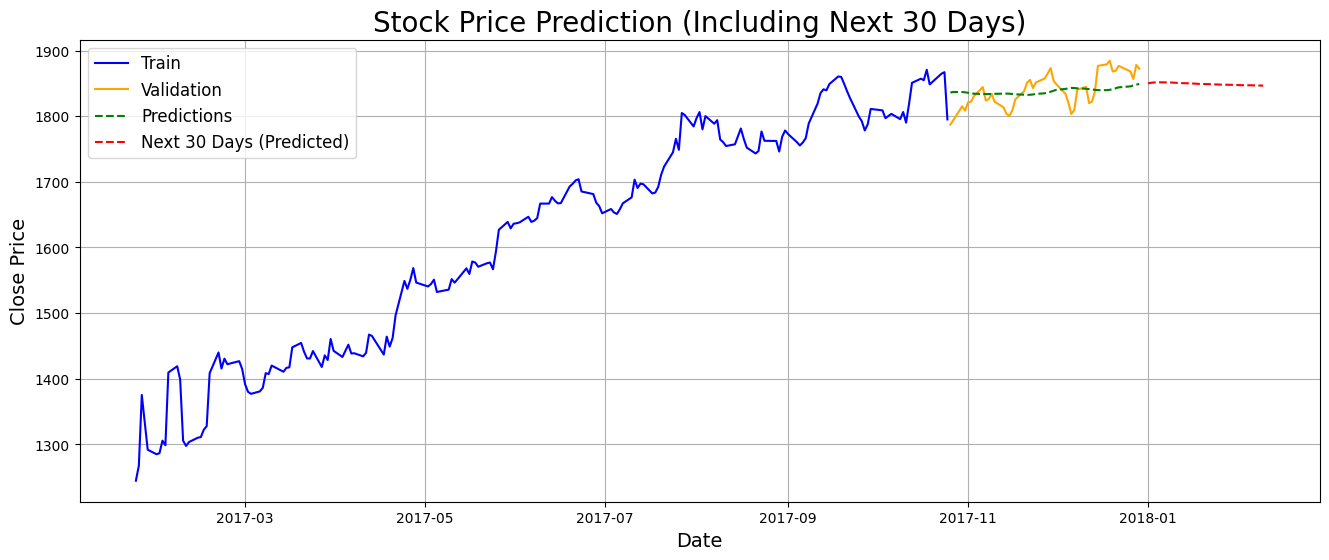

In [89]:
# Step 1: Predict the next 30 days
last_60_days = scaled_data[-60:]  # Use the last 60 days of data as input
input_data = np.array(last_60_days).reshape(1, 60, 1)

# Predict the next 30 days
future_predictions = []

for day in range(30):
    next_day_price = model.predict(input_data)[0, 0]  # Predict the next day
    future_predictions.append(next_day_price)
    # Update input_data with the new prediction
    # Reshape next_day_price to match the dimensions of input_data[:, 1:, :]
    next_day_price_reshaped = next_day_price.reshape(1, 1, 1)
    input_data = np.concatenate([input_data[:, 1:, :], next_day_price_reshaped], axis=1)

# Convert future predictions back to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Step 2: Prepare data for plotting
valid = data[training_data_len:].copy()  # Validation data
valid['Predictions'] = predictions  # Add predictions to the validation dataset

# Create a time range for the next 30 days
future_dates = pd.date_range(start=data.index[-1], periods=31, freq='B')[1:]  # Business days only

# ... (rest of the code remains the same)

# Step 3: Visualize training, validation, and future predictions
plt.figure(figsize=(16, 6))
plt.title('Stock Price Prediction (Including Next 30 Days)', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)

# Plot training and validation data
plt.plot(data['CLOSE'][:training_data_len], label='Train', color='blue')
plt.plot(valid['CLOSE'], label='Validation', color='orange')
plt.plot(valid['Predictions'], label='Predictions', color='green', linestyle='--')

# Plot future predictions
plt.plot(future_dates, future_predictions, label='Next 30 Days (Predicted)', color='red', linestyle='--')

# Add a legend
plt.legend(loc='upper left', fontsize=12)
plt.grid()

# Display the plot
plt.show()
